## This is a test for the third module of this analysis: station-based!

With INPUT: INCIDENT_CODE + DATE, the aims are PER STATION

-- Table output of train arrivals per period defined (hourly, 30min., etc.)

-- Delay minutes for that same defined period

-- Cancellation count

**Parameters:**
- `incident_code`: The incident number to analyze
- `incident_date`: When the incident occurred (format: 'DD-MMM-YYYY')
- `station_id`: Specific station to focus on
- `interval_minutes`: How to group the data (e.g., 15min, 30min, 60min intervals)

**Returns:**
1. **Detailed DataFrame**: Train-by-train records with delays and timestamps
2. **Summary DataFrame**: Aggregated statistics by time intervals
3. **Analysis Info**: Metadata about the incident lifecycle and parameters

In [1]:
# Import required libraries for station_view function
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime, timedelta
import sys
import matplotlib.pyplot as plt

print(" Libraries imported successfully for station_view analysis")

 Libraries imported successfully for station_view analysis


In [3]:
# Diagnostic: Check EVENT_DATETIME column and test date filling
import pandas as pd
import os

# Load one station's data to examine structure
test_station = '73000'
processed_base = '../processed_data'
station_folder = os.path.join(processed_base, test_station)

# Load one day file
test_file = os.path.join(station_folder, 'MO.parquet')
if os.path.exists(test_file):
    df_test = pd.read_parquet(test_file, engine='fastparquet')
    
    print(f"📊 EXAMINING DATA STRUCTURE FOR STATION {test_station}")
    print("=" * 80)
    print(f"\nTotal rows: {len(df_test)}")
    print(f"\nColumns in data: {df_test.columns.tolist()}")
    
    # Check EVENT_DATETIME
    if 'EVENT_DATETIME' in df_test.columns:
        print(f"\n✓ EVENT_DATETIME column exists!")
        print(f"  - Non-null values: {df_test['EVENT_DATETIME'].notna().sum()} ({100*df_test['EVENT_DATETIME'].notna().sum()/len(df_test):.1f}%)")
        print(f"  - Null values: {df_test['EVENT_DATETIME'].isna().sum()} ({100*df_test['EVENT_DATETIME'].isna().sum()/len(df_test):.1f}%)")
        
        # Show some examples
        print(f"\n📅 Sample EVENT_DATETIME values (non-null):")
        print(df_test[df_test['EVENT_DATETIME'].notna()][['EVENT_DATETIME', 'INCIDENT_NUMBER', 'TRAIN_SERVICE_CODE', 'PLANNED_CALLS']].head(5))
        
        print(f"\n📅 Sample rows with NULL EVENT_DATETIME:")
        print(df_test[df_test['EVENT_DATETIME'].isna()][['EVENT_DATETIME', 'INCIDENT_NUMBER', 'TRAIN_SERVICE_CODE', 'PLANNED_CALLS']].head(5))
        
        # Check if data is chronologically sorted
        print(f"\n🔍 CHECKING CHRONOLOGICAL ORDER:")
        df_test_sorted = df_test.sort_index()
        non_null_dates = df_test_sorted[df_test_sorted['EVENT_DATETIME'].notna()]['EVENT_DATETIME']
        if len(non_null_dates) > 1:
            # Compare values directly to avoid index mismatch
            is_sorted = (non_null_dates.values == non_null_dates.sort_values().values).all()
            print(f"  - Data appears chronologically sorted: {is_sorted}")
            print(f"  - Date range of incidents: {non_null_dates.min()} to {non_null_dates.max()}")
    else:
        print(f"\n✗ EVENT_DATETIME column NOT FOUND in data")
        print(f"   Available datetime-like columns: {[col for col in df_test.columns if 'DATE' in col.upper() or 'TIME' in col.upper()]}")
else:
    print(f"Test file not found: {test_file}")

📊 EXAMINING DATA STRUCTURE FOR STATION 73000

Total rows: 14247

Columns in data: ['TRAIN_SERVICE_CODE', 'PLANNED_ORIGIN_LOCATION_CODE', 'PLANNED_ORIGIN_GBTT_DATETIME', 'PLANNED_DEST_LOCATION_CODE', 'PLANNED_DEST_GBTT_DATETIME', 'PLANNED_CALLS', 'ACTUAL_CALLS', 'PFPI_MINUTES', 'INCIDENT_REASON', 'INCIDENT_NUMBER', 'EVENT_TYPE', 'SECTION_CODE', 'DELAY_DAY', 'EVENT_DATETIME', 'INCIDENT_START_DATETIME', 'ENGLISH_DAY_TYPE', 'STATION_ROLE', 'DFT_CATEGORY', 'PLATFORM_COUNT', 'DATASET_TYPE', 'WEEKDAY']

✓ EVENT_DATETIME column exists!
  - Non-null values: 2634 (18.5%)
  - Null values: 11613 (81.5%)

📅 Sample EVENT_DATETIME values (non-null):
         EVENT_DATETIME  INCIDENT_NUMBER TRAIN_SERVICE_CODE PLANNED_CALLS
1173  05-NOV-2024 00:01         957363.0           25506005          2343
1182  11-JUN-2024 00:02         543922.0           25392003          2340
1183  30-APR-2024 00:04         380106.0           25905000          2354
1196  24-DEC-2024 00:05         114785.0           25370002  

In [1]:
def station_view_yearly(station_id, interval_minutes=30):
    """
    Station analysis for yearly data across all incidents - simplified output.
    Analyzes all days of the week for a station and separates incident vs normal operations.
    """
    
    # Load data from all day files
    processed_base = '../processed_data'
    station_folder = os.path.join(processed_base, station_id)
    
    if not os.path.exists(station_folder):
        print(f"Station folder not found: {station_folder}")
        return None, None
    
    # Define day files to load
    day_files = ['MO.parquet', 'TU.parquet', 'WE.parquet', 'TH.parquet', 'FR.parquet', 'SA.parquet', 'SU.parquet']
    
    all_station_data = []
    
    for day_file in day_files:
        file_path = os.path.join(station_folder, day_file)
        if os.path.exists(file_path):
            try:
                day_data = pd.read_parquet(file_path, engine='fastparquet')
                day_data['day_of_week'] = day_file.replace('.parquet', '')
                all_station_data.append(day_data)
                print(f"Loaded {len(day_data)} records from {day_file}")
            except Exception as e:
                print(f"Error loading {day_file}: {e}")
        else:
            print(f"File not found: {day_file}")
    
    if not all_station_data:
        print("No data files found for this station")
        return None, None
    
    # Combine all data
    combined_data = pd.concat(all_station_data, ignore_index=True)
    print(f"Total combined records: {len(combined_data)}")
    
    # Filter for trains with planned calls
    train_mask = combined_data['PLANNED_CALLS'].notna()
    all_train_data = combined_data[train_mask].copy()
    
    # Maximum delay deduplication
    if len(all_train_data) > 0:
        all_train_data['delay_numeric'] = pd.to_numeric(all_train_data['PFPI_MINUTES'], errors='coerce').fillna(0)
        all_train_data['dedup_priority'] = all_train_data['delay_numeric'] * 1000
        
        if 'ACTUAL_CALLS' in all_train_data.columns:
            all_train_data['dedup_priority'] += all_train_data['ACTUAL_CALLS'].notna().astype(int) * 100
        
        basic_dedup_cols = ['TRAIN_SERVICE_CODE', 'PLANNED_CALLS', 'day_of_week']
        basic_available = [col for col in basic_dedup_cols if col in all_train_data.columns]
        
        if len(basic_available) >= 2:
            all_train_data = all_train_data.sort_values(['delay_numeric', 'dedup_priority'], ascending=[False, False])
            all_train_data = all_train_data.drop_duplicates(subset=basic_available, keep='first')
            all_train_data = all_train_data.drop(['delay_numeric', 'dedup_priority'], axis=1)
    
    if len(all_train_data) == 0:
        return None, None
    
    # Separate incident and normal operations
    # Assume trains with incident codes are incident-related
    incident_mask = all_train_data['INCIDENT_NUMBER'].notna()
    incident_data = all_train_data[incident_mask].copy()
    normal_data = all_train_data[~incident_mask].copy()
    
    print(f"Incident-related records: {len(incident_data)}")
    print(f"Normal operations records: {len(normal_data)}")
    
    def process_operations_data(data, operation_type):
        """Process data for either incident or normal operations"""
        if len(data) == 0:
            return pd.DataFrame()
        
        # Process times - using a reference date for time parsing
        reference_date = datetime(2024, 1, 1)  # Use a standard reference date
        
        def parse_time_simple(time_val, base_date):
            if pd.isna(time_val):
                return None
            try:
                time_str = str(int(time_val)).zfill(4)
                hour = int(time_str[:2])
                minute = int(time_str[2:])
                return base_date.replace(hour=hour, minute=minute, second=0, microsecond=0)
            except:
                return None
        
        # Parse times and apply corrected timing logic
        data['planned_dt'] = data['PLANNED_CALLS'].apply(
            lambda x: parse_time_simple(x, reference_date))
        data['original_actual_dt'] = data['ACTUAL_CALLS'].apply(
            lambda x: parse_time_simple(x, reference_date))
        data['delay_minutes'] = pd.to_numeric(data['PFPI_MINUTES'], errors='coerce').fillna(0)
        
        # Create corrected actual times
        corrected_actual_times = []
        for _, row in data.iterrows():
            planned_dt = row['planned_dt']
            original_actual_dt = row['original_actual_dt']
            delay_min = row['delay_minutes']
            
            if pd.isna(planned_dt):
                corrected_actual_times.append(None)
                continue
                
            if delay_min > 0:
                corrected_actual = planned_dt + timedelta(minutes=delay_min)
                corrected_actual_times.append(corrected_actual)
            elif delay_min == 0:
                corrected_actual_times.append(planned_dt)
            else:
                if pd.notna(original_actual_dt):
                    corrected_actual_times.append(original_actual_dt)
                else:
                    corrected_actual_times.append(planned_dt)
        
        data['effective_time'] = corrected_actual_times
        valid_data = data[data['effective_time'].notna()].copy()
        
        if len(valid_data) == 0:
            return pd.DataFrame()
        
        # Group by time intervals (using hour of day for grouping)
        valid_data['hour_of_day'] = valid_data['effective_time'].dt.hour
        valid_data['interval_group'] = (valid_data['hour_of_day'] * 60 + valid_data['effective_time'].dt.minute) // interval_minutes
        
        intervals = []
        
        for interval_group in valid_data['interval_group'].unique():
            interval_trains = valid_data[valid_data['interval_group'] == interval_group]
            
            if len(interval_trains) > 0:
                arrival_trains = interval_trains[interval_trains['EVENT_TYPE'] != 'C']
                cancellation_trains = interval_trains[interval_trains['EVENT_TYPE'] == 'C']
                
                if len(arrival_trains) > 0 or len(cancellation_trains) > 0:
                    if len(arrival_trains) > 0:
                        delay_values = arrival_trains['delay_minutes'].tolist()
                        ontime_arrivals = len([d for d in delay_values if d == 0.0])
                        delayed_arrivals = len([d for d in delay_values if d > 0.0])
                        delayed_minutes = [round(d, 1) for d in delay_values if d > 0.0]
                    else:
                        ontime_arrivals = 0
                        delayed_arrivals = 0
                        delayed_minutes = []
                    
                    total_cancellations = len(cancellation_trains)
                    
                    # Calculate time period label
                    start_minute = interval_group * interval_minutes
                    end_minute = start_minute + interval_minutes
                    start_hour = start_minute // 60
                    start_min = start_minute % 60
                    end_hour = end_minute // 60
                    end_min = end_minute % 60
                    
                    intervals.append({
                        'time_period': f"{start_hour:02d}:{start_min:02d}-{end_hour:02d}:{end_min:02d}",
                        'ontime_arrival_count': ontime_arrivals,
                        'delayed_arrival_count': delayed_arrivals,
                        'cancellation_count': total_cancellations,
                        'delay_minutes': delayed_minutes,
                        'operation_type': operation_type
                    })
        
        return pd.DataFrame(intervals)
    
    # Process both incident and normal operations
    incident_summary = process_operations_data(incident_data, 'incident')
    normal_summary = process_operations_data(normal_data, 'normal')
    
    return incident_summary, normal_summary

print("station_view_yearly function ready!")

station_view_yearly function ready!


In [2]:
# Test the updated yearly analysis function
incident_summary, normal_summary = station_view_yearly(
    station_id='12931', 
    interval_minutes=60
)

# Display the results
print("📊 YEARLY STATION ANALYSIS RESULTS:")
print("=" * 80)

if incident_summary is not None and len(incident_summary) > 0:
    print("\n🔴 INCIDENT OPERATIONS:")
    print("-" * 40)
    print(incident_summary.to_string(index=False))
    print(f"Total incident periods: {len(incident_summary)}")
    
if normal_summary is not None and len(normal_summary) > 0:
    print("\n🟢 NORMAL OPERATIONS:")
    print("-" * 40)
    print(normal_summary.to_string(index=False))
    print(f"Total normal periods: {len(normal_summary)}")

print("=" * 80)

NameError: name 'os' is not defined

In [3]:
def plot_hourly_arrivals_violin(station_id):
    """
    Create violin plots comparing the distribution of scheduled vs actual arrival hours for a station.
    
    - Left plot: Distribution of scheduled arrival hours (from PLANNED_CALLS)
    - Right plot: Distribution of actual arrival hours (PLANNED_CALLS + PFPI_MINUTES, excluding cancellations)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import os

    # Set style
    plt.style.use('default')
    sns.set_palette("husl")

    print(f"🚀 CREATING VIOLIN PLOTS FOR STATION {station_id}")
    print("=" * 60)

    # Load data from all day files
    processed_base = '../processed_data'
    station_folder = os.path.join(processed_base, str(station_id))
    
    if not os.path.exists(station_folder):
        print(f"Error: Station folder {station_folder} not found")
        return None

    all_data = []
    day_files = ['MO.parquet', 'TU.parquet', 'WE.parquet', 'TH.parquet', 'FR.parquet', 'SA.parquet', 'SU.parquet']
    
    for day_file in day_files:
        file_path = os.path.join(station_folder, day_file)
        if os.path.exists(file_path):
            try:
                df = pd.read_parquet(file_path, engine='fastparquet')
                all_data.append(df)
            except Exception as e:
                print(f"Error loading {day_file}: {e}")
    
    if not all_data:
        print("No data files found for this station.")
        return None
    
    data = pd.concat(all_data, ignore_index=True)
    print(f"Loaded {len(data)} total records")

    # Helper function to convert HHMM to hour of day
    def hhmm_to_hour(hhmm):
        if pd.isna(hhmm):
            return np.nan
        try:
            hhmm_str = str(int(hhmm)).zfill(4)
            hour = int(hhmm_str[:2])
            return hour
        except:
            return np.nan

    # SCHEDULED ARRIVALS: All trains with PLANNED_CALLS
    scheduled_data = data[data['PLANNED_CALLS'].notna()].copy()
    if len(scheduled_data) > 0:
        scheduled_data['hour'] = scheduled_data['PLANNED_CALLS'].apply(hhmm_to_hour)
        scheduled_data = scheduled_data.dropna(subset=['hour'])
        print(f"Scheduled: {len(scheduled_data)} trains")
    else:
        scheduled_data = pd.DataFrame()
        print("No scheduled data found")

    # ACTUAL ARRIVALS: Exclude EVENT_TYPE 'C', calculate actual time
    actual_data = data[(data['PLANNED_CALLS'].notna()) & (data['EVENT_TYPE'] != 'C')].copy()
    if len(actual_data) > 0:
        # Calculate actual time: PLANNED_CALLS + PFPI_MINUTES (in minutes)
        actual_data['delay_minutes'] = pd.to_numeric(actual_data['PFPI_MINUTES'], errors='coerce').fillna(0)
        
        def calculate_actual_hhmm(planned_hhmm, delay_min):
            if pd.isna(planned_hhmm):
                return np.nan
            try:
                planned_str = str(int(planned_hhmm)).zfill(4)
                planned_minutes = int(planned_str[:2]) * 60 + int(planned_str[2:])
                actual_minutes = planned_minutes + delay_min
                actual_hour = actual_minutes // 60
                actual_min = actual_minutes % 60
                # Keep within 24 hours
                actual_hour = actual_hour % 24
                return actual_hour * 100 + actual_min
            except:
                return np.nan
        
        actual_data['actual_calls'] = actual_data.apply(
            lambda row: calculate_actual_hhmm(row['PLANNED_CALLS'], row['delay_minutes']), axis=1
        )
        
        actual_data['hour'] = actual_data['actual_calls'].apply(hhmm_to_hour)
        actual_data = actual_data.dropna(subset=['hour'])
        print(f"Actual: {len(actual_data)} trains")
    else:
        actual_data = pd.DataFrame()
        print("No actual data found")

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Left plot: Scheduled
    if not scheduled_data.empty:
        sns.violinplot(x=scheduled_data['hour'], ax=ax1, color='lightgreen', alpha=0.7)
        ax1.set_title(f'Scheduled Arrival Hours Distribution\nStation {station_id}', fontsize=16, color='darkgreen')
        ax1.set_xlabel('Hour of Day', fontsize=14)
        ax1.set_ylabel('Density', fontsize=14)
        ax1.set_xlim(0, 23)
        ax1.grid(True, alpha=0.3, axis='y')
    else:
        ax1.text(0.5, 0.5, 'No Scheduled Data', ha='center', va='center', transform=ax1.transAxes, fontsize=14)
        ax1.set_title(f'Scheduled Arrival Hours Distribution\nStation {station_id}', fontsize=16, color='darkgreen')
    
    # Right plot: Actual
    if not actual_data.empty:
        sns.violinplot(x=actual_data['hour'], ax=ax2, color='lightcoral', alpha=0.7)
        ax2.set_title(f'Actual Arrival Hours Distribution\nStation {station_id}', fontsize=16, color='darkred')
        ax2.set_xlabel('Hour of Day', fontsize=14)
        ax2.set_ylabel('Density', fontsize=14)
        ax2.set_xlim(0, 23)
        ax2.grid(True, alpha=0.3, axis='y')
    else:
        ax2.text(0.5, 0.5, 'No Actual Data', ha='center', va='center', transform=ax2.transAxes, fontsize=14)
        ax2.set_title(f'Actual Arrival Hours Distribution\nStation {station_id}', fontsize=16, color='darkred')
    
    plt.suptitle(f'Station {station_id} - Distribution of Train Arrival Hours\nScheduled vs Actual (with Delays)', 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    # Print summary statistics
    print(f"\n{'='*80}")
    print(f"📊 STATION {station_id} ARRIVAL HOURS DISTRIBUTION ANALYSIS")
    print(f"{'='*80}")
    
    if not scheduled_data.empty:
        print(f"\n📅 SCHEDULED ARRIVALS:")
        print(f"  • Total trains: {len(scheduled_data)}")
        print(f"  • Mean arrival hour: {scheduled_data['hour'].mean():.1f}")
        print(f"  • Std arrival hour: {scheduled_data['hour'].std():.1f}")
        print(f"  • Earliest hour: {scheduled_data['hour'].min():.0f}")
        print(f"  • Latest hour: {scheduled_data['hour'].max():.0f}")
    
    if not actual_data.empty:
        print(f"\n🚨 ACTUAL ARRIVALS:")
        print(f"  • Total trains: {len(actual_data)}")
        print(f"  • Mean arrival hour: {actual_data['hour'].mean():.1f}")
        print(f"  • Std arrival hour: {actual_data['hour'].std():.1f}")
        print(f"  • Earliest hour: {actual_data['hour'].min():.0f}")
        print(f"  • Latest hour: {actual_data['hour'].max():.0f}")
        print(f"  • Trains with hour change due to delay: {(actual_data['PLANNED_CALLS'].apply(hhmm_to_hour) != actual_data['hour']).sum()}")
    
    plt.show()
    return scheduled_data[['hour']] if not scheduled_data.empty else None, actual_data[['hour']] if not actual_data.empty else None

print("plot_hourly_arrivals_violin function ready!")

plot_hourly_arrivals_violin function ready!


🚀 CREATING VIOLIN PLOTS FOR STATION 40050
Loaded 20124 total records
Scheduled: 20124 trains
Actual: 19932 trains

📊 STATION 40050 ARRIVAL HOURS DISTRIBUTION ANALYSIS

📅 SCHEDULED ARRIVALS:
  • Total trains: 20124
  • Mean arrival hour: 13.5
  • Std arrival hour: 5.7
  • Earliest hour: 0
  • Latest hour: 23

🚨 ACTUAL ARRIVALS:
  • Total trains: 19932
  • Mean arrival hour: 13.5
  • Std arrival hour: 5.7
  • Earliest hour: 0
  • Latest hour: 23
  • Trains with hour change due to delay: 626


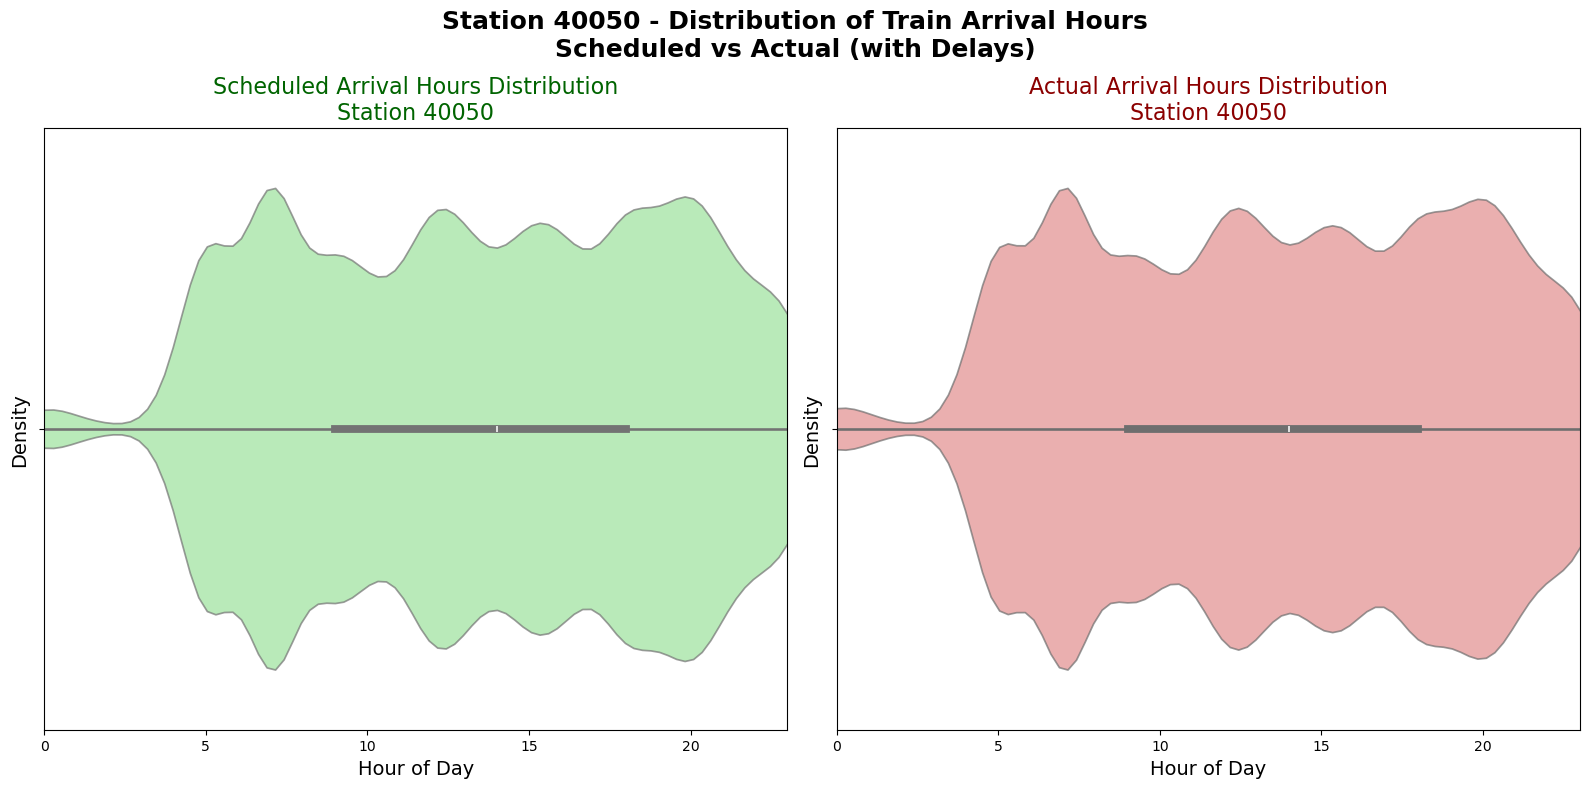

In [4]:
violin_results = plot_hourly_arrivals_violin(station_id='40050')

In [ ]:
def plot_flow_rate_vs_delays_ultra_smooth_kde(station_id, time_window_minutes=30, num_platforms=12, figsize=(14, 10), remove_outliers=True, lower_percentile=1, upper_percentile=99, bw_adjust=1, delay_transform='log1p', trim_threshold=2.0, normalize_density=True, show_marginals=True, marginal_kind='kde', var_bins=6):
    """
    2D KDE plot for a station showing per-train flow rate (trains/hour/platform) vs delay.

    New params:
    - normalize_density: if True, scale KDE and point densities to [0,1] so colorbar is comparable across runs
    - show_marginals: if True, draw marginal KDEs or histograms at top/right
    - marginal_kind: 'kde' or 'hist' for marginals
    - var_bins: number of bins for computing delay variance across binned flow rates
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import gaussian_kde
    import seaborn as sns
    import os
    import pandas as pd

    plt.style.use('default')
    sns.set_palette("husl")

    print(f"🚀 CREATING 2D KDE (flow vs delay) FOR STATION {station_id}")
    print("=" * 60)

    processed_base = '../processed_data'
    station_folder = os.path.join(processed_base, str(station_id))
    if not os.path.exists(station_folder):
        print(f"Error: Station folder {station_folder} not found")
        return None

    all_data = []
    for fname in os.listdir(station_folder):
        if fname.endswith('.parquet'):
            df = pd.read_parquet(os.path.join(station_folder, fname), engine='fastparquet')
            all_data.append(df)
    if not all_data:
        print("Error: No data files found for this station.")
        return None
    data = pd.concat(all_data, ignore_index=True)

    # Helper function to convert HHMM to minutes past midnight
    def time_to_minutes(t):
        try:
            s = str(int(t)).zfill(4)
            return int(s[:2]) * 60 + int(s[2:])
        except Exception:
            return np.nan

    # PLANNED: All trains with PLANNED_CALLS (including cancellations)
    valid_planned = data[data['PLANNED_CALLS'].notna()].copy()
    if len(valid_planned) == 0:
        print("No planned data found.")
        planned_data_points = np.array([])
    else:
        planned_minutes = valid_planned['PLANNED_CALLS'].apply(time_to_minutes).dropna()
        planned_hours = (planned_minutes / 60.0).astype(int)  # floor to hour
        planned_hourly_counts = planned_hours.value_counts().sort_index()
        planned_rates = planned_hourly_counts / num_platforms
        planned_data_points = planned_rates.values
        print(f"Planned: {len(valid_planned)} trains, {len(planned_data_points)} hours with arrivals")

    # ACTUAL: Trains with PLANNED_CALLS and EVENT_TYPE != 'C' (exclude cancellations)
    valid_actual = data[(data['PLANNED_CALLS'].notna()) & (data['EVENT_TYPE'] != 'C')].copy()
    if len(valid_actual) == 0:
        print("No actual data found.")
        actual_data_points = np.array([])
    else:
        planned_minutes_actual = valid_actual['PLANNED_CALLS'].apply(time_to_minutes)
        delay_minutes = pd.to_numeric(valid_actual['PFPI_MINUTES'], errors='coerce').fillna(0)
        actual_minutes = planned_minutes_actual + delay_minutes
        actual_hours = (actual_minutes / 60.0).astype(int)  # floor to hour
        actual_hourly_counts = actual_hours.value_counts().sort_index()
        actual_rates = actual_hourly_counts / num_platforms
        actual_data_points = actual_rates.values
        print(f"Actual: {len(valid_actual)} trains, {len(actual_data_points)} hours with arrivals")

    results = {}

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # LEFT PLOT: PLANNED ARRIVALS (hourly arrival rates per platform)
    if len(planned_data_points) > 0:
        ax1.bar(range(len(planned_data_points)), planned_data_points, color='lightgreen', alpha=0.7, edgecolor='darkgreen')
        
        # Set labels and title
        ax1.set_ylabel('Train Arrivals per Hour', fontsize=16)
        ax1.set_xlabel('Hour of Day', fontsize=16)
        ax1.set_title(f'PLANNED Schedule\n(Hourly Arrival Rates)\n{len(planned_data_points)} hours', 
                     fontsize=18, color='darkgreen')
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.set_ylim(fixed_y_range[0], fixed_y_range[1])
        
        # X-axis ticks for hours
        ax1.set_xticks(range(0, 24, 2))
        ax1.set_xticklabels([f"{h:02d}:00" for h in range(0, 24, 2)], fontsize=14)
    
    # RIGHT PLOT: ACTUAL ARRIVALS (hourly arrival rates per platform)
    if len(actual_data_points) > 0:
        ax2.bar(range(len(actual_data_points)), actual_data_points, color='lightcoral', alpha=0.7, edgecolor='darkred')
        
        # Set labels and title
        ax2.set_ylabel('Train Arrivals per Hour', fontsize=16)
        ax2.set_xlabel('Hour of Day', fontsize=16)
        ax2.set_title(f'ACTUAL Arrivals (with delays adjusted)\n(Hourly Arrival Rates)\n{len(actual_data_points)} hours', 
                     fontsize=18, color='darkred')
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.set_ylim(fixed_y_range[0], fixed_y_range[1])
        
        # X-axis ticks for hours
        ax2.set_xticks(range(0, 24, 2))
        ax2.set_xticklabels([f"{h:02d}:00" for h in range(0, 24, 2)], fontsize=14)
    
    plt.suptitle(f'Station {station_id} - Hourly Train Arrivals (Planned vs Actual)\nAll Yearly Data', 
                 fontsize=20, fontweight='bold', y=0.95)
    plt.tight_layout()
    
    # Print summary statistics
    print(f"\n{'='*80}")
    print(f"🚆 STATION {station_id} HOURLY ARRIVALS ANALYSIS")
    print(f"{'='*80}")
    
    if 'planned_stats' in results:
        planned_stats = results['planned_stats']
        print(f"\n📅 PLANNED SCHEDULE:")
        print(f"  • Total trains: {planned_stats['train_count']:,}")
        print(f"  • Average arrivals per hour: {planned_stats['mean_hourly_arrivals']:.1f}")
        print(f"  • Peak hour arrivals: {planned_stats['max_hourly_arrivals']:.1f}")
        print(f"  • Minimum hour arrivals: {planned_stats['min_hourly_arrivals']:.1f}")
        print(f"  • Service consistency (std): {planned_stats['std_hourly_arrivals']:.1f}")
    
    if 'actual_stats' in results:
        actual_stats = results['actual_stats']
        print(f"\n🚨 ACTUAL OPERATIONS (WITH DELAYS ADJUSTED):")
        print(f"  • Total trains: {actual_stats['train_count']:,}")
        print(f"  • Average arrivals per hour: {actual_stats['mean_hourly_arrivals']:.1f}")
        print(f"  • Peak hour arrivals: {actual_stats['max_hourly_arrivals']:.1f}")
        print(f"  • Minimum hour arrivals: {actual_stats['min_hourly_arrivals']:.1f}")
        print(f"  • Service consistency (std): {actual_stats['std_hourly_arrivals']:.1f}")
    
    plt.show()
    return results

Testing ULTRA-SMOOTH 2D KDE flow rate vs delays function...
🚀 CREATING 2D KDE (flow vs delay) FOR STATION 36151
PLATFORM_COUNT missing or all NaN, using num_platforms=11 for all trains.
Normalizing counts by 215 unique days using column 'PLANNED_ORIGIN_GBTT_DATETIME'
Removing 7 trains with 0.0 delay (keeping only positive delays)
Removing 435 outliers (outside 1th-99th percentiles)
✨ Using 14,988 trains for 2D KDE visualization (total counts, per-platform units)
PLATFORM_COUNT missing or all NaN, using num_platforms=11 for all trains.
Normalizing counts by 215 unique days using column 'PLANNED_ORIGIN_GBTT_DATETIME'
Removing 7 trains with 0.0 delay (keeping only positive delays)
Removing 435 outliers (outside 1th-99th percentiles)
✨ Using 14,988 trains for 2D KDE visualization (total counts, per-platform units)


C:\Users\39342\AppData\Local\Temp\ipykernel_31620\2704380295.py:73: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  uniq_days = pd.to_datetime(valid_trains[date_col], errors='coerce').dt.date.dropna().unique()


KDE failed: 'Colorbar' object has no attribute 'set_clim'


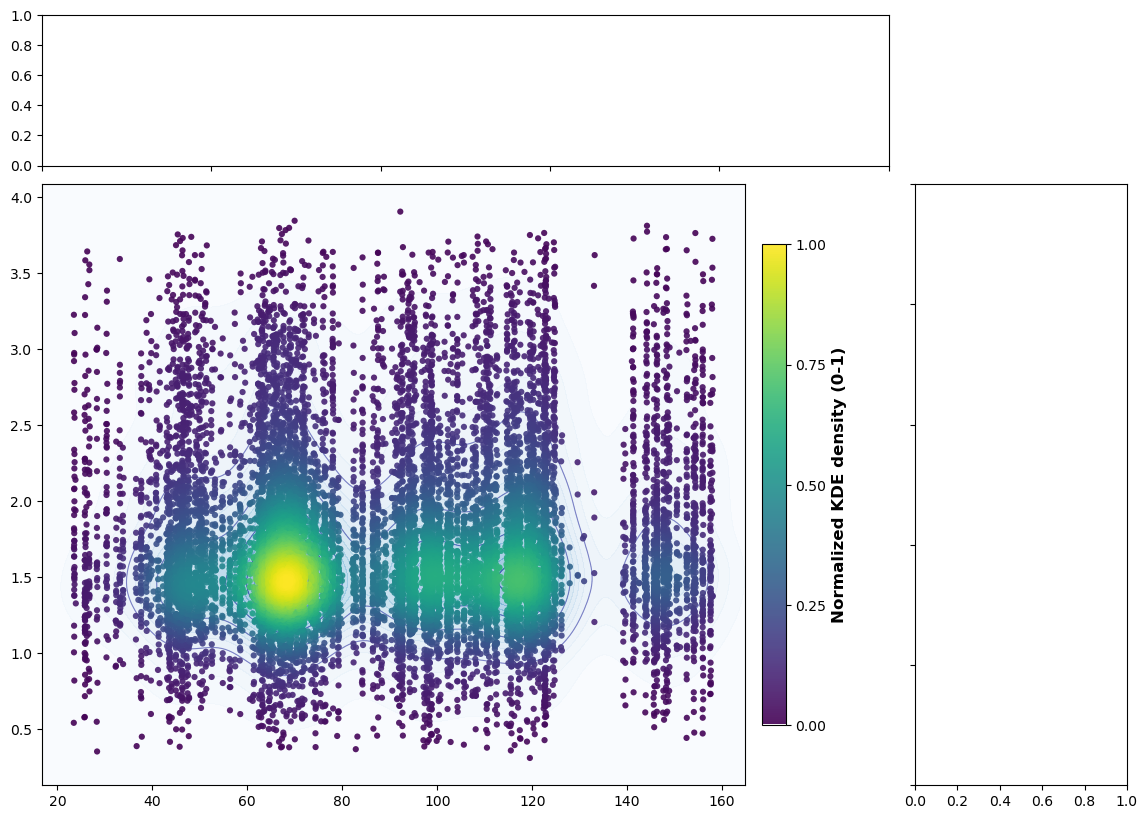

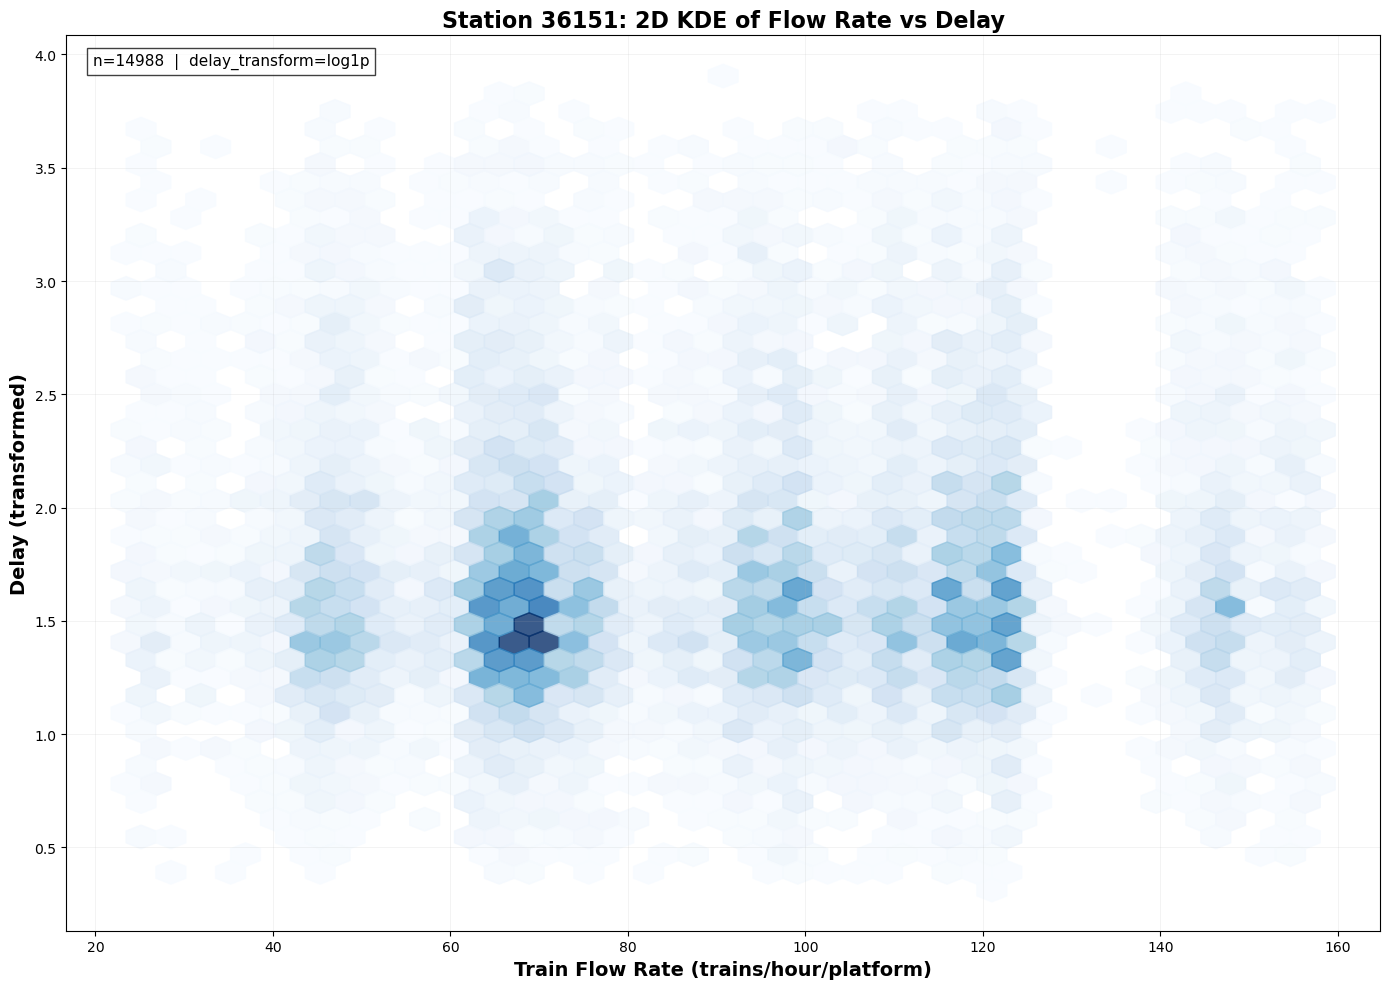


🔎 Delay variance by binned flow rate:
flow_bin
(23.317, 45.878]      30.769959
(45.878, 68.306]      32.104350
(68.306, 90.733]      27.622296
(90.733, 113.16]      31.579397
(113.16, 135.587]     33.212358
(135.587, 158.014]    34.156975
Name: delay, dtype: float64

📊 Dataset: 14,988 trains (total counts)
📊 Flow Rate Range: 23.45 - 158.01 (trains/hour/platform)
📊 Delay Range (log1p): 0.312 - 3.905
✅ Visualization generated (bw_adjust=1, delay_transform=log1p, normalize_density=True)


C:\Users\39342\AppData\Local\Temp\ipykernel_31620\2704380295.py:275: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  var_by_bin = df_var.groupby('flow_bin')['delay'].var()


In [ ]:
# Test the ultra-smooth 2D KDE function
print("Testing ULTRA-SMOOTH 2D KDE flow rate vs delays function...")
ultra_smooth_results = plot_flow_rate_vs_delays_ultra_smooth_kde(
    station_id='36151',
    time_window_minutes=60,
    num_platforms=11,
    figsize=(14, 10)
)
plt.show()

The local KDE density is an estimate of the joint probability density at a specific point in the 2D space (flow, delay). High values mean many trains lie close to that point in the plotted variable space.